# Stock Market Analysis

### This notebook uses LSTM models to predict whether stock prices go up or down.
### For this, Technical Indicators are calculated on stock data.

In [1]:
# Import Modules

import numpy as np
import pandas as pd
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

## Read the data from Stock folder

### Check how much data is available? 

In [2]:
list = os.listdir("./Stocks/")
number_files = len(list)
print(number_files)

7196


### Choose 15 random stock data for analysis

In [3]:
#filenames = [x for x in os.listdir("./Stocks/") if x.endswith('.txt') and os.path.getsize(x) > 0]
filenames = random.sample([x for x in os.listdir("./Stocks/") if x.endswith('.txt') 
                           and os.path.getsize(os.path.join("./Stocks",x)) > 0], 15)
print(filenames)

['infr.us.txt', 'yin.us.txt', 'gst_b.us.txt', 'gvp.us.txt', 'tg.us.txt', 'cato.us.txt', 'dwld.us.txt', 'any.us.txt', 'gnrc.us.txt', 'amgp.us.txt', 'tpor.us.txt', 'hil.us.txt', 'lvhe.us.txt', 'pbi.us.txt', 'banf.us.txt']


### Read data into dataframes

In [4]:
df = []
for filename in filenames:
    dff = pd.read_csv(os.path.join("./Stocks",filename), sep=',')
    label, _, _ = filename.split(sep='.')
    dff['Label'] = label
    dff['Date'] = pd.to_datetime(dff['Date'])
    df.append(dff)

In [5]:
df[0].head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label
0,2017-01-06,24.966,24.966,24.966,24.966,765,0,infr
1,2017-01-09,24.945,25.004,24.759,24.759,6962,0,infr
2,2017-01-10,24.719,24.719,24.719,24.719,103,0,infr
3,2017-01-11,24.837,25.053,24.705,25.043,1223,0,infr
4,2017-01-12,24.867,24.915,24.867,24.915,272,0,infr


In [6]:
# We will consider the data with maximum entries among those 15 random datasets
len_of_data = []
for i in range(len(df)):
    len_of_data.append(len(df[i]))
print(max(len_of_data))

index = len_of_data.index(max(len_of_data))
print(index)

9044
13


## Add various Technical Indicators in the dataframe

There are four types of Technical Indicators. Lets us take 4 sets of indicators and test which performs better in prediction of stock markets.
These 4 sets of Technical Indicators are:
- RSI, Volume (plain), Bollinger Bands, Aroon, Price Volume Trend, acceleration bands
- Stochastic, Chaikin Money Flow, Parabolic SAR, Rate of Change, Volume weighted average Price, momentum
- Commodity Channel Index, On Balance Volume, Keltner Channels, Triple Exponential Moving Average, Normalized Averager True Range ,directional movement indicators
- MACD, Money flowindex , Ichimoku, William %R, Volume MINMAX, adaptive moving average

In [7]:

# Create 4 copies of data to add columns of different sets of Technical Indicators
data = df[index]
techindi1 = copy.deepcopy(data)
techindi2 = copy.deepcopy(data)
techindi3 = copy.deepcopy(data)
techindi4 = copy.deepcopy(data)

# techindi1 dataframe

### Calculation of Relative Strength Index (RSI)

In [8]:
# Relative Strength Index
# Avg(PriceUp)/(Avg(PriceUP)+Avg(PriceDown)*100
# Where: PriceUp(t)=1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)>0};
#        PriceDown(t)=-1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)<0};

def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)


In [9]:
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)

techindi1['Momentum_1D'] = (techindi1['Close']-techindi1['Close'].shift(1)).fillna(0)
techindi1['RSI_14D'] = techindi1['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)
techindi1.tail(5)

,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-0.27,25.212465
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-0.32,26.773455
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,0.14,28.008999
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-0.25,20.039101
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-0.18,19.730510


### Calculation of Volume (Plain)

In [10]:

techindi1['Volume_plain'] = techindi1['Volume'].fillna(0)
techindi1.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-0.27,25.212465,3086405
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-0.32,26.773455,3392871
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,0.14,28.008999,2829247
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-0.25,20.039101,3667578
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-0.18,19.730510,4293186


### Calculation of Bollinger Bands

In [11]:
def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    ave = pd.stats.moments.rolling_mean(price,length)
    sd = pd.stats.moments.rolling_std(price,length)
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [12]:
techindi1['BB_Middle_Band'], techindi1['BB_Upper_Band'], techindi1['BB_Lower_Band'] = bbands(techindi1['Close'], length=20, numsd=1)
techindi1['BB_Middle_Band'] = techindi1['BB_Middle_Band'].fillna(0)
techindi1['BB_Upper_Band'] = techindi1['BB_Upper_Band'].fillna(0)
techindi1['BB_Lower_Band'] = techindi1['BB_Lower_Band'].fillna(0)
techindi1.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  after removing the cwd from sys.path.


,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-0.27,25.212465,3086405,13.360,14.482,12.239
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-0.32,26.773455,3392871,13.187,14.445,11.930
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,0.14,28.008999,2829247,13.030,14.381,11.680
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-0.25,20.039101,3667578,12.865,14.309,11.422
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-0.18,19.730510,4293186,12.690,14.215,11.165


### Calculation of Aroon Oscillator

In [13]:
def aroon(df, tf=25):
    aroonup = []
    aroondown = []
    x = tf
    while x< len(df['Date']):
        aroon_up = ((df['High'][x-tf:x].tolist().index(max(df['High'][x-tf:x])))/float(tf))*100
        aroon_down = ((df['Low'][x-tf:x].tolist().index(min(df['Low'][x-tf:x])))/float(tf))*100
        aroonup.append(aroon_up)
        aroondown.append(aroon_down)
        x+=1
    return aroonup, aroondown

In [14]:
listofzeros = [0] * 25
up, down = aroon(techindi1)
aroon_list = [x - y for x, y in zip(up,down)]
if len(aroon_list)==0:
    aroon_list = [0] * techindi1.shape[0]
    techindi1['Aroon_Oscillator'] = aroon_list
else:
    techindi1['Aroon_Oscillator'] = listofzeros+aroon_list


### Calculation of Price Volume Trend

PVT = [((CurrentClose - PreviousClose) / PreviousClose) x Volume] + PreviousPVT

In [15]:
techindi1["PVT"] = (techindi1['Momentum_1D']/ techindi1['Close'].shift(1))*techindi1['Volume']
techindi1["PVT"] = techindi1["PVT"]-techindi1["PVT"].shift(1)
techindi1["PVT"] = techindi1["PVT"].fillna(0)
techindi1.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-0.27,25.212465,3086405,13.360,14.482,12.239,-36.0,-105060.706595
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-0.32,26.773455,3392871,13.187,14.445,11.930,-44.0,-24807.766339
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,0.14,28.008999,2829247,13.030,14.381,11.680,-48.0,136038.576395
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-0.25,20.039101,3667578,12.865,14.309,11.422,-52.0,-122054.728945
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-0.18,19.730510,4293186,12.690,14.215,11.165,-56.0,11648.967799


### Calculation of Acceleration Bands

In [16]:
def abands(df):
    df['AB_Middle_Band'] = pd.rolling_mean(df['Close'], 20)
    # High * ( 1 + 4 * (High - Low) / (High + Low))
    df['aupband'] = df['High'] * (1 + 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df['AB_Upper_Band'] = pd.rolling_mean(df['aupband'], 20)
    # Low *(1 - 4 * (High - Low)/ (High + Low))
    df['adownband'] = df['Low'] * (1 - 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df['AB_Lower_Band'] = pd.rolling_mean(df['adownband'], 20)

In [17]:
abands(techindi1)
techindi1 = techindi1.fillna(0)
techindi1.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  """
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  


,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,...,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,aupband,AB_Upper_Band,adownband,AB_Lower_Band
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-0.27,25.212465,...,13.360,14.482,12.239,-36.0,-105060.706595,13.3605,11.837573,14.378763,10.387573,12.530938
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-0.32,26.773455,...,13.187,14.445,11.930,-44.0,-24807.766339,13.1875,12.495234,14.257114,9.395234,12.339289
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,0.14,28.008999,...,13.030,14.381,11.680,-48.0,136038.576395,13.0305,11.325844,14.102814,10.075844,12.162489
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-0.25,20.039101,...,12.865,14.309,11.422,-52.0,-122054.728945,12.8655,11.865471,13.982464,9.527971,11.971514
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-0.18,19.730510,...,12.690,14.215,11.165,-56.0,11648.967799,12.6900,11.496913,13.844239,9.396913,11.763289


## Drop unwanted columns

In [18]:
columns2Drop = ['Momentum_1D', 'aupband', 'adownband']
techindi1 = techindi1.drop(labels = columns2Drop, axis=1)
techindi1.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band
0,1982-01-04,0.6183,0.6251,0.6183,0.6251,939818,0,pbi,0.0,939818,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,1982-01-05,0.6183,0.6251,0.6183,0.6183,815430,0,pbi,0.0,815430,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,1982-01-06,0.6111,0.6183,0.6043,0.6111,778572,0,pbi,0.0,778572,0.0,0.0,0.0,0.0,-195.881485,0.0,0.0,0.0
3,1982-01-07,0.6043,0.6043,0.5972,0.5972,170456,0,pbi,0.0,170456,0.0,0.0,0.0,0.0,5189.170917,0.0,0.0,0.0
4,1982-01-08,0.6043,0.6043,0.5972,0.6043,142816,0,pbi,0.0,142816,0.0,0.0,0.0,0.0,5575.082621,0.0,0.0,0.0


# techindi2 dataframe

### Calculation of Stochastic Oscillator (%K and %D)

In [19]:
def STOK(df, n):
    df['STOK'] = ((df['Close'] - pd.rolling_mean(df['Low'], n)) / (pd.rolling_max(df['High'], n) - pd.rolling_min(df['Low'],n))) * 100
    df['STOD'] = pd.rolling_mean(df['STOK'], 3)

In [20]:
STOK(techindi2, 4)
techindi2 = techindi2.fillna(0)
techindi2.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).max()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).min()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-4.735683,-22.023343
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-25.000000,-16.169470
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,-0.721154,-10.152279
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-11.532508,-12.417887
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-8.812500,-7.022054


### Calculation of Chaikin Money Flow

In [21]:
def CMFlow(df, tf):
    CHMF = []
    MFMs = []
    MFVs = []
    x = tf
    
    while x < len(df['Date']):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        
        MFM = ((df['Close'][x] - df['Low'][x]) - (df['High'][x] - df['Close'][x])) / (df['High'][x] - df['Low'][x])
        MFV = MFM*PeriodVolume
        
        MFMs.append(MFM)
        MFVs.append(MFV)
        x+=1
    
    y = tf
    while y < len(MFVs):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        consider = MFVs[y-tf:y]
        tfsMFV = 0
        
        for eachMFV in consider:
            tfsMFV += eachMFV
        
        tfsCMF = tfsMFV/PeriodVolume
        CHMF.append(tfsCMF)
        y+=1
    return CHMF

In [22]:
listofzeros = [0] * 40
CHMF = CMFlow(techindi2, 20)
if len(CHMF)==0:
    CHMF = [0] * techindi2.shape[0]
    techindi2['Chaikin_MF'] = CHMF
else:
    techindi2['Chaikin_MF'] = listofzeros+CHMF
techindi2.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-4.735683,-22.023343,-2.102984
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-25.000000,-16.169470,-2.473151
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,-0.721154,-10.152279,-3.337384
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-11.532508,-12.417887,-2.135136
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-8.812500,-7.022054,-2.864485


### Calculation of Parabolic SAR

In [23]:
def psar(df, iaf = 0.02, maxaf = 0.2):
    length = len(df)
    dates = (df['Date'])
    high = (df['High'])
    low = (df['Low'])
    close = (df['Close'])
    psar = df['Close'][0:len(df['Close'])]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = df['Low'][0]
    hp = df['High'][0]
    lp = df['Low'][0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if df['Low'][i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = df['Low'][i]
                af = iaf
        else:
            if df['High'][i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = df['High'][i]
                af = iaf
        if not reverse:
            if bull:
                if df['High'][i] > hp:
                    hp = df['High'][i]
                    af = min(af + iaf, maxaf)
                if df['Low'][i - 1] < psar[i]:
                    psar[i] = df['Low'][i - 1]
                if df['Low'][i - 2] < psar[i]:
                    psar[i] = df['Low'][i - 2]
            else:
                if df['Low'][i] < lp:
                    lp = df['Low'][i]
                    af = min(af + iaf, maxaf)
                if df['High'][i - 1] > psar[i]:
                    psar[i] = df['High'][i - 1]
                if df['High'][i - 2] > psar[i]:
                    psar[i] = df['High'][i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    #return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}
    #return psar, psarbear, psarbull
    df['psar'] = psar
    #df['psarbear'] = psarbear
    #df['psarbull'] = psarbull

In [24]:
psar(techindi2)

techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar
9039,2017-11-06,11.18,11.25,10.9600,14.027324,3086405,0,pbi,-4.735683,-22.023343,-2.102984,14.027324
9040,2017-11-07,10.98,11.22,10.6000,13.843284,3392871,0,pbi,-25.000000,-16.169470,-2.473151,13.843284
9041,2017-11-08,10.63,10.82,10.5700,13.583821,2829247,0,pbi,-0.721154,-10.152279,-3.337384,13.583821
9042,2017-11-09,10.76,10.91,10.4425,13.282439,3667578,0,pbi,-11.532508,-12.417887,-2.135136,13.282439
9043,2017-11-10,10.55,10.64,10.2200,12.941647,4293186,0,pbi,-8.812500,-7.022054,-2.864485,12.941647


### Calculation of Price Rate of Change

In [25]:
# ROC = [(Close - Close n periods ago) / (Close n periods ago)] * 100

techindi2['ROC'] = ((techindi2['Close'] - techindi2['Close'].shift(12))/(techindi2['Close'].shift(12)))*100
techindi2 = techindi2.fillna(0)
techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC
9039,2017-11-06,11.18,11.25,10.9600,14.027324,3086405,0,pbi,-4.735683,-22.023343,-2.102984,14.027324,0.214263
9040,2017-11-07,10.98,11.22,10.6000,13.843284,3392871,0,pbi,-25.000000,-16.169470,-2.473151,13.843284,2.771226
9041,2017-11-08,10.63,10.82,10.5700,13.583821,2829247,0,pbi,-0.721154,-10.152279,-3.337384,13.583821,0.714900
9042,2017-11-09,10.76,10.91,10.4425,13.282439,3667578,0,pbi,-11.532508,-12.417887,-2.135136,13.282439,-1.643997
9043,2017-11-10,10.55,10.64,10.2200,12.941647,4293186,0,pbi,-8.812500,-7.022054,-2.864485,12.941647,-4.285995


### Calculation of Volume Weighted Average Price

In [26]:
techindi2['VWAP'] = np.cumsum(techindi2['Volume'] * (techindi2['High'] + techindi2['Low'])/2) / np.cumsum(techindi2['Volume'])
techindi2 = techindi2.fillna(0)
techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC,VWAP
9039,2017-11-06,11.18,11.25,10.9600,14.027324,3086405,0,pbi,-4.735683,-22.023343,-2.102984,14.027324,0.214263,15.973157
9040,2017-11-07,10.98,11.22,10.6000,13.843284,3392871,0,pbi,-25.000000,-16.169470,-2.473151,13.843284,2.771226,15.971939
9041,2017-11-08,10.63,10.82,10.5700,13.583821,2829247,0,pbi,-0.721154,-10.152279,-3.337384,13.583821,0.714900,15.970881
9042,2017-11-09,10.76,10.91,10.4425,13.282439,3667578,0,pbi,-11.532508,-12.417887,-2.135136,13.282439,-1.643997,15.969506
9043,2017-11-10,10.55,10.64,10.2200,12.941647,4293186,0,pbi,-8.812500,-7.022054,-2.864485,12.941647,-4.285995,15.967821


### Calculation of Momentum 

In [27]:
techindi2['Momentum'] = techindi2['Close'] - techindi2['Close'].shift(4)
techindi2 = techindi2.fillna(0)
techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC,VWAP,Momentum
9039,2017-11-06,11.18,11.25,10.9600,14.027324,3086405,0,pbi,-4.735683,-22.023343,-2.102984,14.027324,0.214263,15.973157,0.442593
9040,2017-11-07,10.98,11.22,10.6000,13.843284,3392871,0,pbi,-25.000000,-16.169470,-2.473151,13.843284,2.771226,15.971939,-0.496716
9041,2017-11-08,10.63,10.82,10.5700,13.583821,2829247,0,pbi,-0.721154,-10.152279,-3.337384,13.583821,0.714900,15.970881,-0.693379
9042,2017-11-09,10.76,10.91,10.4425,13.282439,3667578,0,pbi,-11.532508,-12.417887,-2.135136,13.282439,-1.643997,15.969506,-0.867273
9043,2017-11-10,10.55,10.64,10.2200,12.941647,4293186,0,pbi,-8.812500,-7.022054,-2.864485,12.941647,-4.285995,15.967821,-1.085677


# techindi3 dataframe

### Calculation of Commodity Channel Index

In [28]:
def CCI(df, n, constant):
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((TP - pd.rolling_mean(TP, n)) / (constant * pd.rolling_std(TP,n))) #, name = 'CCI_' + str(n))
    return CCI

In [29]:
techindi3['CCI'] = CCI(techindi3, 20, 0.015)
techindi3 = techindi3.fillna(0)
techindi3.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-149.434562
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-136.621345
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,-121.396821
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-109.871788
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-105.621389


### Calculation of On Balance Volume

            
If the closing price is above the prior close price then: 
Current OBV = Previous OBV + Current Volume

If the closing price is below the prior close price then: 
Current OBV = Previous OBV  -  Current Volume

If the closing prices equals the prior close price then:
Current OBV = Previous OBV (no change)

In [30]:
new = (techindi3['Volume'] * (~techindi3['Close'].diff().le(0) * 2 -1)).cumsum()
techindi3['OBV'] = new
techindi3.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-149.434562,-288523774
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-136.621345,-291916645
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,-121.396821,-289087398
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-109.871788,-292754976
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-105.621389,-297048162


### Calcualtion of Keltner Channels

In [31]:
#Keltner Channel  
def KELCH(df, n):  
    KelChM = pd.Series(pd.rolling_mean((df['High'] + df['Low'] + df['Close']) / 3, n), name = 'KelChM_' + str(n))  
    KelChU = pd.Series(pd.rolling_mean((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3, n), name = 'KelChU_' + str(n))  
    KelChD = pd.Series(pd.rolling_mean((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3, n), name = 'KelChD_' + str(n))    
    return KelChM, KelChD, KelChU

In [32]:
KelchM, KelchD, KelchU = KELCH(techindi3, 14)
techindi3['Kelch_Upper'] = KelchU
techindi3['Kelch_Middle'] = KelchM
techindi3['Kelch_Down'] = KelchD
techindi3 = techindi3.fillna(0)
techindi3.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  """


,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-149.434562,-288523774,13.636014,13.209493,12.782971
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-136.621345,-291916645,13.464110,13.005445,12.546781
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,-121.396821,-289087398,13.252919,12.789255,12.325590
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-109.871788,-292754976,13.000895,12.538838,12.076781
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-105.621389,-297048162,12.747562,12.270505,11.793448


### Calculation of Triple Exponential Moving Average

Triple Exponential MA Formula:

T-EMA = (3*EMA – 3*EMA(EMA)) + EMA(EMA(EMA))

Where:

EMA = EMA(1) + α * (Close – EMA(1))

α = 2 / (N + 1)

N = The smoothing period.

In [33]:
techindi3['EMA'] = pd.ewma(techindi3['Close'], span = 3)
techindi3 = techindi3.fillna(0)


techindi3['TEMA'] = (3 * techindi3['EMA'] - 3 * techindi3['EMA'] * techindi3['EMA']) + (techindi3['EMA']*techindi3['EMA']*techindi3['EMA'])
techindi3.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=3,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down,EMA,TEMA
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-149.434562,-288523774,13.636014,13.209493,12.782971,11.273870,1085.431807
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-136.621345,-291916645,13.464110,13.005445,12.546781,10.966935,991.113320
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,-121.396821,-289087398,13.252919,12.789255,12.325590,10.883468,966.446090
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-109.871788,-292754976,13.000895,12.538838,12.076781,10.716734,918.404602
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-105.621389,-297048162,12.747562,12.270505,11.793448,10.543367,870.170269


### Calculation of Normalized Average True Range

True Range = Highest of (HIgh - low, abs(High - previous close), abs(low - previous close))

Average True Range = 14 day MA of True Range

Normalized Average True Range = ATR / Close * 100

In [34]:
techindi3['HL'] = techindi3['High'] - techindi3['Low']
techindi3['absHC'] = abs(techindi3['High'] - techindi3['Close'].shift(1))
techindi3['absLC'] = abs(techindi3['Low'] - techindi3['Close'].shift(1))
techindi3['TR'] = techindi3[['HL','absHC','absLC']].max(axis=1)
techindi3['ATR'] = techindi3['TR'].rolling(window=14).mean()
techindi3['NATR'] = (techindi3['ATR'] / techindi3['Close']) *100
techindi3 = techindi3.fillna(0)
techindi3.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,...,Kelch_Middle,Kelch_Down,EMA,TEMA,HL,absHC,absLC,TR,ATR,NATR
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-149.434562,-288523774,...,13.209493,12.782971,11.273870,1085.431807,0.2900,0.00,0.2900,0.2900,0.468307,4.265092
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-136.621345,-291916645,...,13.005445,12.546781,10.966935,991.113320,0.6200,0.24,0.3800,0.6200,0.500450,4.694653
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,-121.396821,-289087398,...,12.789255,12.325590,10.883468,966.446090,0.2500,0.16,0.0900,0.2500,0.505450,4.680093
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-109.871788,-292754976,...,12.538838,12.076781,10.716734,918.404602,0.4675,0.11,0.3575,0.4675,0.500986,4.748680
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-105.621389,-297048162,...,12.270505,11.793448,10.543367,870.170269,0.4200,0.09,0.3300,0.4200,0.515986,4.975754


### Calculation of Average Directional Movement Index (ADX)

Calculating the DMI can actually be broken down into two parts. 
First, calculating the +DI and -DI, and second, calculating the ADX.

To calculate the +DI and -DI you need to find the +DM and -DM (Directional Movement). 
+DM and -DM are calculated using the High, Low and Close for each period. 
You can then calculate the following:

Current High - Previous High = UpMove
Previous Low - Current Low = DownMove

If UpMove > DownMove and UpMove > 0, then +DM = UpMove, else +DM = 0
If DownMove > Upmove and Downmove > 0, then -DM = DownMove, else -DM = 0

Once you have the current +DM and -DM calculated, the +DM and -DM lines can be 
calculated and plotted based on the number of user defined periods.

+DI = 100 times Exponential Moving Average of (+DM / Average True Range)
-DI = 100 times Exponential Moving Average of (-DM / Average True Range)

Now that -+DX and -DX have been calculated, the last step is calculating the ADX.

ADX = 100 times the Exponential Moving Average of the Absolute Value of (+DI - -DI) / (+DI + -DI)

In [35]:
def DMI(df, period):
    df['UpMove'] = df['High'] - df['High'].shift(1)
    df['DownMove'] = df['Low'].shift(1) - df['Low']
    df['Zero'] = 0

    df['PlusDM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > df['Zero']), df['UpMove'], 0)
    df['MinusDM'] = np.where((df['UpMove'] < df['DownMove']) & (df['DownMove'] > df['Zero']), df['DownMove'], 0)

    df['plusDI'] = 100 * pd.ewma(df['PlusDM']/df['ATR'], span = period)
    df['minusDI'] = 100 * pd.ewma(df['MinusDM']/df['ATR'], span = period)

    df['ADX'] = 100 * pd.ewma(abs((df['plusDI'] - df['minusDI'])/(df['plusDI'] + df['minusDI'])), span = period)

In [36]:
DMI(techindi3, 14)
techindi3 = techindi3.fillna(0)
techindi3.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=14,min_periods=0,adjust=True,ignore_na=False).mean()
  if __name__ == '__main__':
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=14,min_periods=0,adjust=True,ignore_na=False).mean()
  # Remove the CWD from sys.path while we load stuff.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=14,min_periods=0,adjust=True,ignore_na=False).mean()
  if sys.path[0] == '':


,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,...,ATR,NATR,UpMove,DownMove,Zero,PlusDM,MinusDM,plusDI,minusDI,ADX
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,-149.434562,-288523774,...,0.468307,4.265092,-0.36,0.1400,0,0.0,0.1400,10.133567,71.642077,46.202720
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,-136.621345,-291916645,...,0.500450,4.694653,-0.03,0.3600,0,0.0,0.3600,8.782424,71.681168,50.465083
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,-121.396821,-289087398,...,0.505450,4.680093,-0.40,0.0300,0,0.0,0.0300,7.611435,62.915053,54.191790
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,-109.871788,-292754976,...,0.500986,4.748680,0.09,0.1275,0,0.0,0.1275,6.596577,57.919689,57.572972
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,-105.621389,-297048162,...,0.515986,4.975754,-0.27,0.2225,0,0.0,0.2225,5.717033,55.946577,60.757556


## Drop Unwanted Columns

In [37]:
columns2Drop = ['UpMove', 'DownMove', 'ATR', 'PlusDM', 'MinusDM', 'Zero', 'EMA', 'HL', 'absHC', 'absLC', 'TR']

techindi3 = techindi3.drop(labels = columns2Drop, axis=1)
techindi3.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down,TEMA,NATR,plusDI,minusDI,ADX
0,1982-01-04,0.6183,0.6251,0.6183,0.6251,939818,0,pbi,0.0,939818,0.0,0.0,0.0,0.947308,0.0,0.0,0.0,0.0
1,1982-01-05,0.6183,0.6251,0.6183,0.6183,815430,0,pbi,0.0,124388,0.0,0.0,0.0,0.945373,0.0,0.0,0.0,0.0
2,1982-01-06,0.6111,0.6183,0.6043,0.6111,778572,0,pbi,0.0,-654184,0.0,0.0,0.0,0.943003,0.0,0.0,0.0,0.0
3,1982-01-07,0.6043,0.6043,0.5972,0.5972,170456,0,pbi,0.0,-824640,0.0,0.0,0.0,0.938641,0.0,0.0,0.0,0.0
4,1982-01-08,0.6043,0.6043,0.5972,0.6043,142816,0,pbi,0.0,-681824,0.0,0.0,0.0,0.938332,0.0,0.0,0.0,0.0


# techindi4 dataframe

### Calculation of MACD

MACD: (12-day EMA - 26-day EMA)

In [38]:
techindi4['26_ema'] = pd.ewma(techindi4['Close'], span=26)
techindi4['12_ema'] = pd.ewma(techindi4['Close'], span = 12)
techindi4['MACD'] = techindi4['12_ema'] - techindi4['26_ema']
techindi4 = techindi4.fillna(0)
techindi4.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
  


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,MACD
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,13.095928,12.558009,-0.537919
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,12.915489,12.266007,-0.649481
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,12.758786,12.040468,-0.718318
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,12.595172,11.811165,-0.784007
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,12.430344,11.589447,-0.840897


### Calculation of Money Flow Index

Typical Price = (High + Low + Close)/3

Raw Money Flow = Typical Price x Volume

The money flow is divided into positive and negative money flow.

- Positive money flow is calculated by adding the money flow of all the days where the typical price is higher than the previous day's typical price.
- Negative money flow is calculated by adding the money flow of all the days where the typical price is lower than the previous day's typical price.
- If typical price is unchanged then that day is discarded.

Money Flow Ratio = (14-period Positive Money Flow)/(14-period Negative Money Flow)

Money Flow Index = 100 - 100/(1 + Money Flow Ratio)

In [39]:
def MFI(df):
    # typical price
    df['tp'] = (df['High']+df['Low']+df['Close'])/3
    #raw money flow
    df['rmf'] = df['tp'] * df['Volume']
    
    # positive and negative money flow
    df['pmf'] = np.where(df['tp'] > df['tp'].shift(1), df['tp'], 0)
    df['nmf'] = np.where(df['tp'] < df['tp'].shift(1), df['tp'], 0)

    # money flow ratio
    df['mfr'] = pd.rolling_sum(df['pmf'], 14, center=False)/pd.rolling_sum(df['nmf'], 14, center=False)
    df['Money_Flow_Index'] = 100 - 100 / (1 + df['mfr'])

In [40]:
MFI(techindi4)
techindi4 = techindi4.fillna(0)
techindi4.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).sum()
  if sys.path[0] == '':


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,MACD,tp,rmf,pmf,nmf,mfr,Money_Flow_Index
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,13.095928,12.558009,-0.537919,11.063333,3.414593e+07,0.0,11.063333,0.826806,45.259659
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,12.915489,12.266007,-0.649481,10.826667,3.673348e+07,0.0,10.826667,0.624817,38.454589
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,12.758786,12.040468,-0.718318,10.730000,3.035782e+07,0.0,10.730000,0.458182,31.421467
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,12.595172,11.811165,-0.784007,10.634167,3.900164e+07,0.0,10.634167,0.315686,23.994021
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,12.430344,11.589447,-0.840897,10.410000,4.469207e+07,0.0,10.410000,0.194345,16.272083


### Calculations of Ichimoku Cloud

Turning Line = ( Highest High + Lowest Low
 ) / 2, for the past 9 days

Standard Line = ( Highest High + Lowest Low
 ) / 2, for the past 26 days

Leading Span 1 = ( Standard Line + Turning
 Line ) / 2, plotted 26 days ahead of today

Leading Span 2 = ( Highest High + Lowest
 Low ) / 2, for the past 52 days, plotted 26 days ahead of today

Cloud = Shaded Area between Span 1 and Span
 2

In [41]:
def ichimoku(df):
    # Turning Line
    period9_high = pd.rolling_max(df['High'], window=9)
    period9_low = pd.rolling_min(df['Low'], window=9)
    df['turning_line'] = (period9_high + period9_low) / 2
    
    # Standard Line
    period26_high = pd.rolling_max(df['High'], window=26)
    period26_low = pd.rolling_min(df['Low'], window=26)
    df['standard_line'] = (period26_high + period26_low) / 2
    
    # Leading Span 1
    df['ichimoku_span1'] = ((df['turning_line'] + df['standard_line']) / 2).shift(26)
    
    # Leading Span 2
    period52_high = pd.rolling_max(df['High'], window=52)
    period52_low = pd.rolling_min(df['Low'], window=52)
    df['ichimoku_span2'] = ((period52_high + period52_low) / 2).shift(26)
    
    # The most current closing price plotted 22 time periods behind (optional)
    df['chikou_span'] = df['Close'].shift(-22) # 22 according to investopedia

In [42]:
ichimoku(techindi4)
techindi4 = techindi4.fillna(0)
techindi4.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=9,center=False).max()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=9,center=False).min()
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).max()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).min()
 

,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,rmf,pmf,nmf,mfr,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,13.095928,12.558009,...,3.414593e+07,0.0,11.063333,0.826806,45.259659,12.63000,12.65000,13.34250,14.116,0.0
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,12.915489,12.266007,...,3.673348e+07,0.0,10.826667,0.624817,38.454589,12.31000,12.47000,13.37250,14.116,0.0
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,12.758786,12.040468,...,3.035782e+07,0.0,10.730000,0.458182,31.421467,12.26500,12.45500,13.41125,14.116,0.0
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,12.595172,11.811165,...,3.900164e+07,0.0,10.634167,0.315686,23.994021,12.18625,12.39125,13.46250,14.116,0.0
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,12.430344,11.589447,...,4.469207e+07,0.0,10.410000,0.194345,16.272083,12.03000,12.28000,13.50375,14.116,0.0


### Calculation of William %R

%R = -100 * ( ( Highest High - Close) / (
 Highest High - Lowest Low ) )

In [43]:
def WillR(df):
    highest_high = pd.rolling_max(df['High'], window=14)
    lowest_low = pd.rolling_min(df['Low'], window=14)
    df['WillR'] = (-100) * ((highest_high - df['Close']) / (highest_high - lowest_low))


In [44]:
WillR(techindi4)
techindi4 = techindi4.fillna(0)
techindi4.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).max()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).min()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,pmf,nmf,mfr,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,13.095928,12.558009,...,0.0,11.063333,0.826806,45.259659,12.63000,12.65000,13.34250,14.116,0.0,-99.408284
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,12.915489,12.266007,...,0.0,10.826667,0.624817,38.454589,12.31000,12.47000,13.37250,14.116,0.0,-98.395722
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,12.758786,12.040468,...,0.0,10.730000,0.458182,31.421467,12.26500,12.45500,13.41125,14.116,0.0,-93.899204
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,12.595172,11.811165,...,0.0,10.634167,0.315686,23.994021,12.18625,12.39125,13.46250,14.116,0.0,-97.213221
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,12.430344,11.589447,...,0.0,10.410000,0.194345,16.272083,12.03000,12.28000,13.50375,14.116,0.0,-96.323529


### Calculation of MINMAX

In [45]:
def MINMAX(df):
    df['MIN_Volume'] = pd.rolling_min(df['Volume'], window=14)
    df['MAX_Volume'] = pd.rolling_max(df['Volume'], window=14)

In [46]:
MINMAX(techindi4)
techindi4 = techindi4.fillna(0)
techindi4.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).min()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).max()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,mfr,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,13.095928,12.558009,...,0.826806,45.259659,12.63000,12.65000,13.34250,14.116,0.0,-99.408284,1191107.0,11611788.0
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,12.915489,12.266007,...,0.624817,38.454589,12.31000,12.47000,13.37250,14.116,0.0,-98.395722,1191107.0,11611788.0
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,12.758786,12.040468,...,0.458182,31.421467,12.26500,12.45500,13.41125,14.116,0.0,-93.899204,1191908.0,11611788.0
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,12.595172,11.811165,...,0.315686,23.994021,12.18625,12.39125,13.46250,14.116,0.0,-97.213221,1191908.0,11611788.0
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,12.430344,11.589447,...,0.194345,16.272083,12.03000,12.28000,13.50375,14.116,0.0,-96.323529,1191908.0,11611788.0


### Calculation of Adaptive Moving Average

In [47]:
def KAMA(price, n=10, pow1=2, pow2=30):
    ''' kama indicator '''    
    ''' accepts pandas dataframe of prices '''

    absDiffx = abs(price - price.shift(1) )  

    ER_num = abs( price - price.shift(n) )
    ER_den = pd.stats.moments.rolling_sum(absDiffx,n)
    ER = ER_num / ER_den

    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0


    answer = np.zeros(sc.size)
    N = len(answer)
    first_value = True

    for i in range(N):
        if sc[i] != sc[i]:
            answer[i] = np.nan
        else:
            if first_value:
                answer[i] = price[i]
                first_value = False
            else:
                answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
    return answer

In [48]:
techindi4['KAMA'] = KAMA(techindi4['Close'])
techindi4 = techindi4.fillna(0)
techindi4.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).sum()
  


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume,KAMA
9039,2017-11-06,11.18,11.25,10.9600,10.98,3086405,0,pbi,13.095928,12.558009,...,45.259659,12.63000,12.65000,13.34250,14.116,0.0,-99.408284,1191107.0,11611788.0,11.911564
9040,2017-11-07,10.98,11.22,10.6000,10.66,3392871,0,pbi,12.915489,12.266007,...,38.454589,12.31000,12.47000,13.37250,14.116,0.0,-98.395722,1191107.0,11611788.0,11.434707
9041,2017-11-08,10.63,10.82,10.5700,10.80,2829247,0,pbi,12.758786,12.040468,...,31.421467,12.26500,12.45500,13.41125,14.116,0.0,-93.899204,1191908.0,11611788.0,11.228257
9042,2017-11-09,10.76,10.91,10.4425,10.55,3667578,0,pbi,12.595172,11.811165,...,23.994021,12.18625,12.39125,13.46250,14.116,0.0,-97.213221,1191908.0,11611788.0,11.003136
9043,2017-11-10,10.55,10.64,10.2200,10.37,4293186,0,pbi,12.430344,11.589447,...,16.272083,12.03000,12.28000,13.50375,14.116,0.0,-96.323529,1191908.0,11611788.0,10.791372


## Drop Unwanted Columns

In [49]:
columns2Drop = ['26_ema', '12_ema','tp','rmf','pmf','nmf','mfr']

techindi4 = techindi4.drop(labels = columns2Drop, axis=1)
techindi4.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,MACD,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume,KAMA
0,1982-01-04,0.6183,0.6251,0.6183,0.6251,939818,0,pbi,0.000000,0.0,0.0,0.0,0.0,0.0,0.5489,0.0,0.0,0.0,0.0
1,1982-01-05,0.6183,0.6251,0.6183,0.6183,815430,0,pbi,-0.000153,0.0,0.0,0.0,0.0,0.0,0.5489,0.0,0.0,0.0,0.0
2,1982-01-06,0.6111,0.6183,0.6043,0.6111,778572,0,pbi,-0.000418,0.0,0.0,0.0,0.0,0.0,0.5834,0.0,0.0,0.0,0.0
3,1982-01-07,0.6043,0.6043,0.5972,0.5972,170456,0,pbi,-0.001030,0.0,0.0,0.0,0.0,0.0,0.5763,0.0,0.0,0.0,0.0
4,1982-01-08,0.6043,0.6043,0.5972,0.6043,142816,0,pbi,-0.001058,0.0,0.0,0.0,0.0,0.0,0.5834,0.0,0.0,0.0,0.0


In [50]:
techindi1.index = techindi1['Date']
techindi1 = techindi1.drop(labels = ['Date'], axis = 1)

techindi2.index = techindi2['Date']
techindi2 = techindi2.drop(labels = ['Date'], axis = 1)

techindi3.index = techindi3['Date']
techindi3 = techindi3.drop(labels = ['Date'], axis = 1)

techindi4.index = techindi4['Date']
techindi4 = techindi4.drop(labels = ['Date'], axis = 1)

# LSTM Model for Prediction of movement of stocks

Add a label column to all dataframes, that represent 1 if Close Price is constant or increasing and 0 if Close Price is decreasing

In [51]:
def normalized_df(df):
    normalized_df=(df-df.mean())/df.std()
    return normalized_df

In [52]:
normalized_df1 = copy.deepcopy(techindi1)
normalized_df2 = copy.deepcopy(techindi2)
normalized_df3 = copy.deepcopy(techindi3)
normalized_df4 = copy.deepcopy(techindi4)

In [53]:
ti_List1 = []
ti_List2 = []
ti_List3 = []
ti_List4 = []

x = normalized_df1['Label'][0]
ti_List1.append(x)
normalized_df1 = normalized_df1.drop('Label', 1)

x = normalized_df2['Label'][0]
ti_List2.append(x)
normalized_df2 = normalized_df2.drop('Label', 1)

x = normalized_df3['Label'][0]
ti_List3.append(x)
normalized_df3 = normalized_df3.drop('Label', 1)

x = normalized_df4['Label'][0]
ti_List4.append(x)
normalized_df4 = normalized_df4.drop('Label', 1)

In [54]:
normalized_df1.head()

,Open,High,Low,Close,Volume,OpenInt,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band
Date,,,,,,,,,,,,,,,,
1982-01-04,0.6183,0.6251,0.6183,0.6251,939818,0,0.0,939818,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1982-01-05,0.6183,0.6251,0.6183,0.6183,815430,0,0.0,815430,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1982-01-06,0.6111,0.6183,0.6043,0.6111,778572,0,0.0,778572,0.0,0.0,0.0,0.0,-195.881485,0.0,0.0,0.0
1982-01-07,0.6043,0.6043,0.5972,0.5972,170456,0,0.0,170456,0.0,0.0,0.0,0.0,5189.170917,0.0,0.0,0.0
1982-01-08,0.6043,0.6043,0.5972,0.6043,142816,0,0.0,142816,0.0,0.0,0.0,0.0,5575.082621,0.0,0.0,0.0


In [55]:

mean = normalized_df1.mean(axis = 0)
normalized_df1 -= mean
std = normalized_df1.std(axis=0)
normalized_df1 /= std
    

mean = normalized_df2.mean(axis = 0)
normalized_df2 -= mean
std = normalized_df2.std(axis = 0)
normalized_df2 /= std
    

mean = normalized_df3.mean(axis = 0)
normalized_df3 -= mean
std = normalized_df3.std(axis = 0)
normalized_df3 /= std
    

mean = normalized_df4.mean(axis = 0)
normalized_df4 -= mean
std = normalized_df4.std(axis = 0)
normalized_df4 /= std


In [56]:
def add_label(df):
    idx = len(df.columns)
    new_col = np.where(df['Close'] >= df['Close'].shift(1), 1, 0)  
    df.insert(loc=idx, column='Label', value=new_col)
    df = df.fillna(0)

In [57]:

add_label(normalized_df1)    
add_label(normalized_df2)
add_label(normalized_df3)
add_label(normalized_df4)

In [58]:
normalized_df1.head()

,Open,High,Low,Close,Volume,OpenInt,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band,Label
Date,,,,,,,,,,,,,,,,,
1982-01-04,-1.489436,-1.489125,-1.489102,-1.488718,-0.348105,NaN,-4.450729,-0.348105,-1.548208,-1.551888,-1.542747,-0.165762,0.000033,-1.548208,-1.54487,-1.549203,0
1982-01-05,-1.489436,-1.489125,-1.489102,-1.489374,-0.417799,NaN,-4.450729,-0.417799,-1.548208,-1.551888,-1.542747,-0.165762,0.000033,-1.548208,-1.54487,-1.549203,0
1982-01-06,-1.490131,-1.489774,-1.490469,-1.490069,-0.438451,NaN,-4.450729,-0.438451,-1.548208,-1.551888,-1.542747,-0.165762,-0.000873,-1.548208,-1.54487,-1.549203,0
1982-01-07,-1.490787,-1.491110,-1.491162,-1.491410,-0.779177,NaN,-4.450729,-0.779177,-1.548208,-1.551888,-1.542747,-0.165762,0.024030,-1.548208,-1.54487,-1.549203,0
1982-01-08,-1.490787,-1.491110,-1.491162,-1.490725,-0.794663,NaN,-4.450729,-0.794663,-1.548208,-1.551888,-1.542747,-0.165762,0.025815,-1.548208,-1.54487,-1.549203,1


In [59]:

normalized_df1 = normalized_df1.fillna(0)    
normalized_df2 = normalized_df2.fillna(0)
normalized_df3 = normalized_df3.fillna(0)
normalized_df4 = normalized_df4.fillna(0)

In [60]:
normalized_df1.head()


,Open,High,Low,Close,Volume,OpenInt,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band,Label
Date,,,,,,,,,,,,,,,,,
1982-01-04,-1.489436,-1.489125,-1.489102,-1.488718,-0.348105,0.0,-4.450729,-0.348105,-1.548208,-1.551888,-1.542747,-0.165762,0.000033,-1.548208,-1.54487,-1.549203,0
1982-01-05,-1.489436,-1.489125,-1.489102,-1.489374,-0.417799,0.0,-4.450729,-0.417799,-1.548208,-1.551888,-1.542747,-0.165762,0.000033,-1.548208,-1.54487,-1.549203,0
1982-01-06,-1.490131,-1.489774,-1.490469,-1.490069,-0.438451,0.0,-4.450729,-0.438451,-1.548208,-1.551888,-1.542747,-0.165762,-0.000873,-1.548208,-1.54487,-1.549203,0
1982-01-07,-1.490787,-1.491110,-1.491162,-1.491410,-0.779177,0.0,-4.450729,-0.779177,-1.548208,-1.551888,-1.542747,-0.165762,0.024030,-1.548208,-1.54487,-1.549203,0
1982-01-08,-1.490787,-1.491110,-1.491162,-1.490725,-0.794663,0.0,-4.450729,-0.794663,-1.548208,-1.551888,-1.542747,-0.165762,0.025815,-1.548208,-1.54487,-1.549203,1


## Let's apply LSTM on one dataframe

We will predict whether the stock goes up or down. It is a classification problem, were class 0 is stock goinf down and class 1 is stock going up.

# Generator yielding timeseries samples and targets

In [61]:
normalized_df1 = normalized_df1.values
type(normalized_df1)

numpy.ndarray

In [62]:
from keras.utils import to_categorical
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=32, step=5):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, to_categorical(targets)

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Preparing the training, validation and test generators

In [63]:
# 10 10, 10, 64
# 5, 5, ,5 ,1
lookback = 5
step = 5
delay = 5
batch_size = 32

In [64]:
train_gen = generator(normalized_df1,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=round(0.6*len(normalized_df1)),
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(normalized_df1,
                    lookback=lookback,
                    delay=delay,
                    min_index=round(0.6*len(normalized_df1))+1,
                    max_index=round(0.8*len(normalized_df1)),
                    step=step,
                    batch_size=batch_size)
test_gen = generator(normalized_df1,
                     lookback=lookback,
                     delay=delay,
                     min_index=round(0.8*len(normalized_df1))+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (round(0.8*len(normalized_df1)) - round(0.6*len(normalized_df1))+1 - lookback) # how many steps to draw from val_gen in order to see the entire validation set
test_steps = (len(normalized_df1) - round(0.8*len(normalized_df1))+1 - lookback)
# How many steps to draw from test_gen in order to see the entire test set

In [65]:
a,b = next(train_gen)

print(b)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


# Training and evaluating a densely connected model

In [66]:
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop

In [67]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, normalized_df1.shape[-1]))) 
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 17)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 144       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 234
Trainable params: 234
Non-trainable params: 0
_________________________________________________________________


In [68]:

model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=2, 
                              epochs=50, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 0.7704 - acc: 0.6562 - val_loss: 0.7077 - val_acc: 0.4963
Epoch 2/50
2/2 [==============================] - 3s 2s/step - loss: 0.7342 - acc: 0.6562 - val_loss: 0.7089 - val_acc: 0.4955
Epoch 3/50
2/2 [==============================] - 3s 2s/step - loss: 0.7162 - acc: 0.5781 - val_loss: 0.7118 - val_acc: 0.4982
Epoch 4/50
2/2 [==============================] - 3s 2s/step - loss: 0.6854 - acc: 0.5000 - val_loss: 0.7139 - val_acc: 0.4962
Epoch 5/50
2/2 [==============================] - 3s 2s/step - loss: 0.7068 - acc: 0.5938 - val_loss: 0.7156 - val_acc: 0.4977
Epoch 6/50
2/2 [==============================] - 3s 2s/step - loss: 0.6951 - acc: 0.4375 - val_loss: 0.7148 - val_acc: 0.4950
Epoch 7/50
2/2 [==============================] - 3s 2s/step - loss: 0.6723 - acc: 0.3906 - val_loss: 0.7165 - val_acc: 0.4960
Epoch 8/50
2/2 [==============================] - 3s 2s/step - loss: 0.6952 - acc: 0.5469 - val_loss: 0.7159 - 

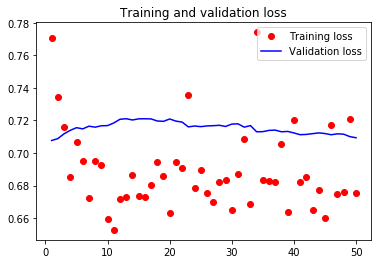

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

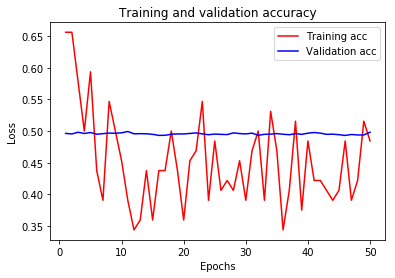

In [70]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [71]:
model.save("LSTM1.h5")

In [72]:
from keras.models import load_model
model = load_model("LSTM1.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=3)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.3541666666666667
test_loss: 0.6611988147099813


## Training and evaluating a GRU-based model

In [73]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, normalized_df1.shape[-1])))

model.add(layers.Dense(2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4800      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 4,866
Trainable params: 4,866
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=2,
                              epochs=50,
                              validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 2.6508 - acc: 0.5625 - val_loss: 1.6624 - val_acc: 0.4971
Epoch 2/50
2/2 [==============================] - 4s 2s/step - loss: 2.0586 - acc: 0.5469 - val_loss: 1.4670 - val_acc: 0.4955
Epoch 3/50
2/2 [==============================] - 3s 2s/step - loss: 0.7499 - acc: 0.4375 - val_loss: 1.3733 - val_acc: 0.4945
Epoch 4/50
2/2 [==============================] - 3s 2s/step - loss: 1.5370 - acc: 0.4062 - val_loss: 1.1749 - val_acc: 0.5206
Epoch 5/50
2/2 [==============================] - 3s 2s/step - loss: 2.5012 - acc: 0.4688 - val_loss: 2.3559 - val_acc: 0.4968
Epoch 6/50
2/2 [==============================] - 3s 2s/step - loss: 2.3031 - acc: 0.4531 - val_loss: 2.3005 - val_acc: 0.4988
Epoch 7/50
2/2 [==============================] - 3s 2s/step - loss: 2.0896 - acc: 0.3906 - val_loss: 2.2089 - val_acc: 0.5177
Epoch 8/50
2/2 [==============================] - 3s 2s/step - loss: 0.8185 - acc: 0.4688 - val_loss: 2.0424 - 

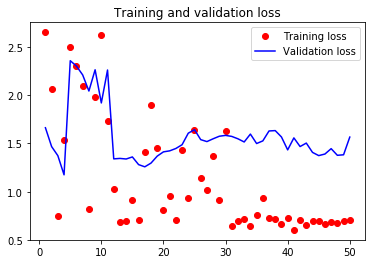

In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

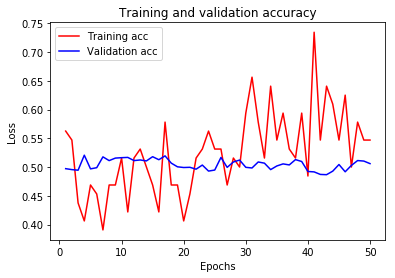

In [76]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:
model.save("GRU.h5")

In [78]:
model = load_model("GRU.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=20)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.509375
test_loss: 1.9092936843633652


# Training and evaluating a dropout-regularized GRU-based model

In [79]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.4,
                     input_shape=(None, normalized_df1.shape[-1])))
model.add(layers.Dense(2))
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=2,
                              epochs=50,
                              validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 3.8794 - acc: 0.4531 - val_loss: 4.5585 - val_acc: 0.5057
Epoch 2/50
2/2 [==============================] - 4s 2s/step - loss: 3.4986 - acc: 0.6250 - val_loss: 4.4282 - val_acc: 0.5071
Epoch 3/50
2/2 [==============================] - 4s 2s/step - loss: 3.0771 - acc: 0.5781 - val_loss: 4.3305 - val_acc: 0.5108
Epoch 4/50
2/2 [==============================] - 4s 2s/step - loss: 2.2665 - acc: 0.4844 - val_loss: 3.6118 - val_acc: 0.5133
Epoch 5/50
2/2 [==============================] - 4s 2s/step - loss: 1.6004 - acc: 0.5156 - val_loss: 3.6068 - val_acc: 0.5152
Epoch 6/50
2/2 [==============================] - 4s 2s/step - loss: 2.6586 - acc: 0.5156 - val_loss: 3.5658 - val_acc: 0.5132
Epoch 7/50
2/2 [==============================] - 4s 2s/step - loss: 5.4369 - acc: 0.5156 - val_loss: 3.4952 - val_acc: 0.5135
Epoch 8/50
2/2 [==============================] - 4s 2s/step - loss: 3.3035 - acc: 0.4688 - val_loss: 3.4167 - 

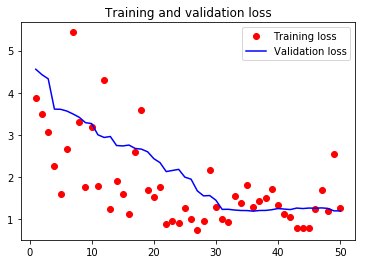

In [80]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

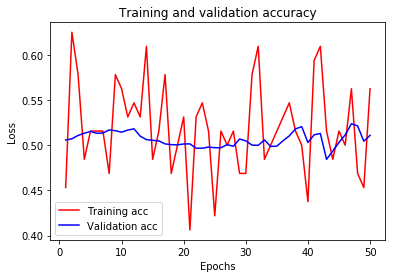

In [81]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
model.save("GRU_dropout.h5")

In [83]:
model = load_model("GRU_dropout.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=20)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.4578125
test_loss: 1.6429441273212433


# Stacking Recurrent Layers

## Training and evaluating a dropout-regularized, stacked GRU model

In [84]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, normalized_df1.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(2))
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=2,
                              epochs=2,
                              validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/2
2/2 [==============================] - 6s 3s/step - loss: 2.7313 - acc: 0.5625 - val_loss: 0.8887 - val_acc: 0.5071
Epoch 2/2
2/2 [==============================] - 5s 2s/step - loss: 0.6925 - acc: 0.5312 - val_loss: 0.9353 - val_acc: 0.5088


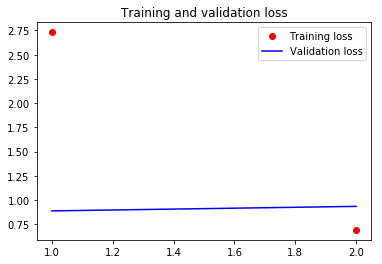

In [85]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

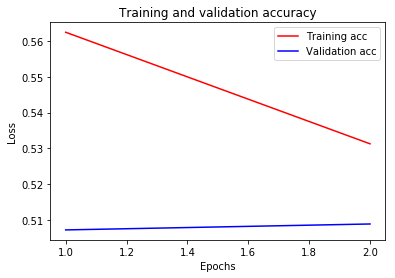

In [86]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [87]:
model.save("GRU_stacked.h5")

In [88]:
model = load_model("GRU_stacked.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=20)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.53125
test_loss: 2.619876688718796


### Normal LSTM model is performing better than others

Let's compare which set of Technical Indicators works well.

In [89]:
normalized_df2 = normalized_df2.values
normalized_df3 = normalized_df3.values
normalized_df4 = normalized_df4.values

In [90]:
lookback = 5
step = 5
delay = 5
batch_size = 32

In [91]:
train_gen = generator(normalized_df2,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=round(0.6*len(normalized_df2)),
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(normalized_df2,
                    lookback=lookback,
                    delay=delay,
                    min_index=round(0.6*len(normalized_df2))+1,
                    max_index=round(0.8*len(normalized_df2)),
                    step=step,
                    batch_size=batch_size)
test_gen = generator(normalized_df2,
                     lookback=lookback,
                     delay=delay,
                     min_index=round(0.8*len(normalized_df2))+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (round(0.8*len(normalized_df2)) - round(0.6*len(normalized_df2))+1 - lookback) # how many steps to draw from val_gen in order to see the entire validation set
test_steps = (len(normalized_df2) - round(0.8*len(normalized_df2))+1 - lookback)

In [92]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, normalized_df2.shape[-1]))) 
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 14)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 120       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 18        
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________


In [93]:

model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=2, 
                              epochs=5, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/5
2/2 [==============================] - 5s 2s/step - loss: 0.6753 - acc: 0.7188 - val_loss: 7.1153 - val_acc: 0.5004
Epoch 2/5
2/2 [==============================] - 3s 1s/step - loss: 0.6585 - acc: 0.6875 - val_loss: 7.1295 - val_acc: 0.4981
Epoch 3/5
2/2 [==============================] - 3s 1s/step - loss: 0.6252 - acc: 0.6406 - val_loss: 7.0552 - val_acc: 0.5005
Epoch 4/5
2/2 [==============================] - 3s 1s/step - loss: 1.3751 - acc: 0.5156 - val_loss: 7.0533 - val_acc: 0.4992
Epoch 5/5
2/2 [==============================] - 3s 1s/step - loss: 0.6973 - acc: 0.4844 - val_loss: 7.0886 - val_acc: 0.4979


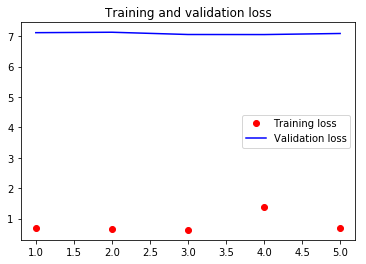

In [94]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

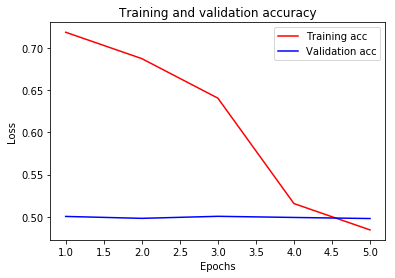

In [95]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [96]:
model.save("LSTM2.h5")

In [97]:

model = load_model("LSTM2.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=3)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.4270833333333333
test_loss: 3.5646172364552817


In [98]:
train_gen = generator(normalized_df3,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=round(0.6*len(normalized_df3)),
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(normalized_df3,
                    lookback=lookback,
                    delay=delay,
                    min_index=round(0.6*len(normalized_df3))+1,
                    max_index=round(0.8*len(normalized_df3)),
                    step=step,
                    batch_size=batch_size)
test_gen = generator(normalized_df3,
                     lookback=lookback,
                     delay=delay,
                     min_index=round(0.8*len(normalized_df3))+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (round(0.8*len(normalized_df3)) - round(0.6*len(normalized_df3))+1 - lookback) # how many steps to draw from val_gen in order to see the entire validation set
test_steps = (len(normalized_df3) - round(0.8*len(normalized_df3))+1 - lookback)

In [99]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, normalized_df3.shape[-1]))) 
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 17)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 144       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 18        
Total params: 234
Trainable params: 234
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=5, 
                              epochs=29, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/29
5/5 [==============================] - 4s 764ms/step - loss: 0.8928 - acc: 0.4188 - val_loss: 3.0136 - val_acc: 0.4882
Epoch 2/29
5/5 [==============================] - 3s 553ms/step - loss: 0.6752 - acc: 0.3563 - val_loss: 3.1960 - val_acc: 0.4889
Epoch 3/29
5/5 [==============================] - 3s 590ms/step - loss: 0.6950 - acc: 0.4375 - val_loss: 2.9966 - val_acc: 0.4893
Epoch 4/29
5/5 [==============================] - 3s 614ms/step - loss: 0.7511 - acc: 0.4750 - val_loss: 2.5963 - val_acc: 0.4884
Epoch 5/29
5/5 [==============================] - 3s 611ms/step - loss: 0.6644 - acc: 0.4125 - val_loss: 2.7621 - val_acc: 0.4898
Epoch 6/29
5/5 [==============================] - 3s 579ms/step - loss: 0.6992 - acc: 0.3813 - val_loss: 2.4125 - val_acc: 0.4885
Epoch 7/29
5/5 [==============================] - 3s 586ms/step - loss: 0.7155 - acc: 0.4500 - val_loss: 2.2736 - val_acc: 0.4882
Epoch 8/29
5/5 [==============================] - 3s 573ms/step - loss: 0.7478 - acc: 0.46

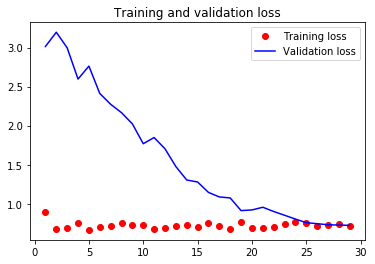

In [101]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

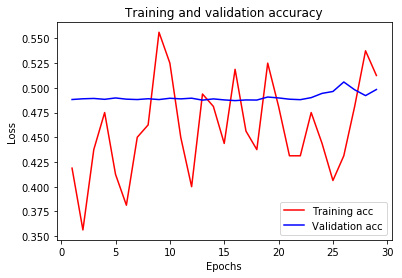

In [102]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [103]:
model.save("LSTM3.h5")

In [104]:
model = load_model("LSTM3.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=3)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.4166666666666667
test_loss: 0.6838484803835551


In [105]:
train_gen = generator(normalized_df4,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=round(0.6*len(normalized_df4)),
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(normalized_df4,
                    lookback=lookback,
                    delay=delay,
                    min_index=round(0.6*len(normalized_df4))+1,
                    max_index=round(0.8*len(normalized_df4)),
                    step=step,
                    batch_size=batch_size)
test_gen = generator(normalized_df4,
                     lookback=lookback,
                     delay=delay,
                     min_index=round(0.8*len(normalized_df4))+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (round(0.8*len(normalized_df4)) - round(0.6*len(normalized_df4))+1 - lookback) # how many steps to draw from val_gen in order to see the entire validation set
test_steps = (len(normalized_df4) - round(0.8*len(normalized_df4))+1 - lookback)

In [107]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, normalized_df4.shape[-1]))) 
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 18)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 152       
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 18        
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________


In [108]:
model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=5, 
                              epochs=50, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/50
5/5 [==============================] - 4s 755ms/step - loss: 0.7637 - acc: 0.3813 - val_loss: 4.5982 - val_acc: 0.4826
Epoch 2/50
5/5 [==============================] - 3s 624ms/step - loss: 0.7849 - acc: 0.5062 - val_loss: 4.6086 - val_acc: 0.4816
Epoch 3/50
5/5 [==============================] - 3s 596ms/step - loss: 0.6727 - acc: 0.6000 - val_loss: 4.7807 - val_acc: 0.4795
Epoch 4/50
5/5 [==============================] - 4s 785ms/step - loss: 0.7005 - acc: 0.5125 - val_loss: 4.8007 - val_acc: 0.4772
Epoch 5/50
5/5 [==============================] - 3s 652ms/step - loss: 0.6903 - acc: 0.5375 - val_loss: 4.8200 - val_acc: 0.4769
Epoch 6/50
5/5 [==============================] - 3s 547ms/step - loss: 0.6748 - acc: 0.6063 - val_loss: 4.7860 - val_acc: 0.4784
Epoch 7/50
5/5 [==============================] - 3s 645ms/step - loss: 0.6913 - acc: 0.5625 - val_loss: 4.5750 - val_acc: 0.4776
Epoch 8/50
5/5 [==============================] - 3s 658ms/step - loss: 0.7078 - acc: 0.51

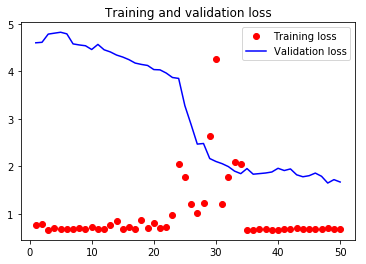

In [109]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

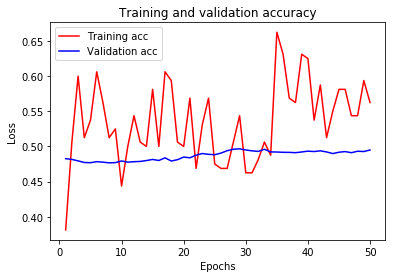

In [110]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [111]:
model.save("LSTM4.h5")

In [112]:
model = load_model("LSTM4.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=3)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.625
test_loss: 2.000559647878011
